# ABR
This markup will be changed when the paper is published in the Journal: Hearing Research

## What to do ?
1. Get data from graph image
2. Generate model
3. Learning and testing

In [1]:
import cv2
import numpy as np
import math
import tensorflow as tf
from matplotlib import pyplot as plt

## Extract data from image

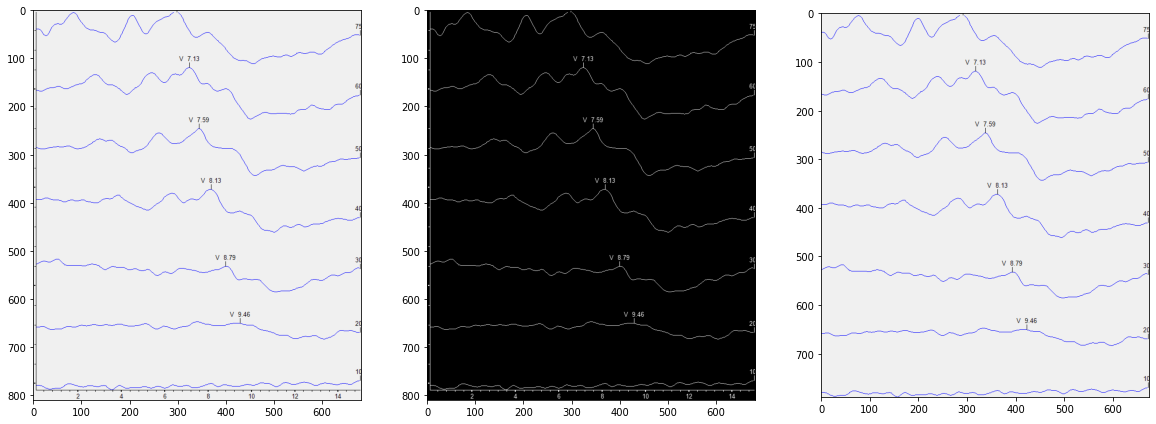

In [2]:
# open image
img = cv2.imread('abr.png')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = 255 - gray
row = cv2.reduce(gray, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32F)
column = cv2.reduce(gray, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32F)

# find out the x and y axis from image
x = np.argmax(row)  # start point x-axis
y = np.argmax(column)  # start point y-axis

# crop the graph content
crop = img[:y, x + 1:]

# show result
plt.figure(figsize=(20,8))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.imshow(gray, cmap='gray')
plt.subplot(133)
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

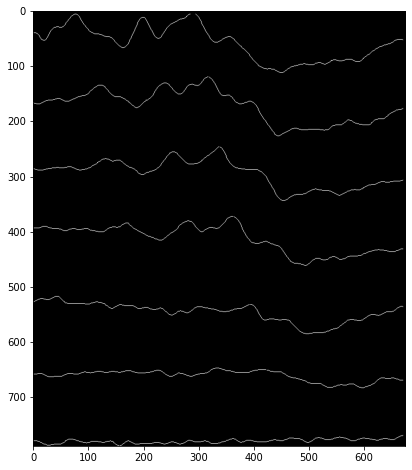

In [3]:
# the range of color
lower_color = (200, 0, 0)
upper_color = (255, 100, 100)

# remove the mark
mask = cv2.inRange(crop, lower_color, upper_color)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
merge = crop & mask_rgb  # extract
gray = cv2.cvtColor(merge, cv2.COLOR_BGR2GRAY)

# show result
plt.figure(figsize=(20,8))
plt.imshow(gray, cmap='gray')

In [4]:
# contours (means vector of graph's values)
graph_lines, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

blank1 = np.zeros(crop.shape, np.uint8)
cv2.drawContours(blank1, graph_lines, -1, (255, 255, 255))
blank1 = cv2.dilate(blank1, np.ones((3, 3), np.uint8), iterations=1)

graph_lines, _ = cv2.findContours(cv2.cvtColor(blank1, cv2.COLOR_BGR2GRAY), cv2.RETR_TREE,
                                  cv2.CHAIN_APPROX_NONE)  # find graph's values

graph_list = []
for graph_line in graph_lines:
    # extract graph line from graph contour
    value_of_contour_list = [[] for x in range(crop.shape[1])]
    for array_item in graph_line:
        for array_item_2 in array_item:
            x = array_item_2[0]
            y = array_item_2[1]
            value_of_contour_list[x].append(y)

    # calculate real y-value of x-values
    real_value_list = []
    for i in range(len(value_of_contour_list)):
        item = value_of_contour_list[i]
        if len(item) != 0:
            real_value_list.append(crop.shape[0] - sum(item) / len(item))
        else:
            real_value_list.append(0)
            
    st = 0
    end = len(real_value_list) - 1

    for i in range(len(real_value_list)):
        if real_value_list[i] != 0:
            st = i
            break

    for j in range(len(real_value_list) - 1, -1, -1):
        if real_value_list[j] != 0:
            end = j
            break

    st_end = {"start": st, "end": end}

    graph = {"value": real_value_list, "st_end": st_end}
    graph_list.append(graph)

print("The count of line graph is: {0}".format(len(graph_list)))

The count of line graph is: 8


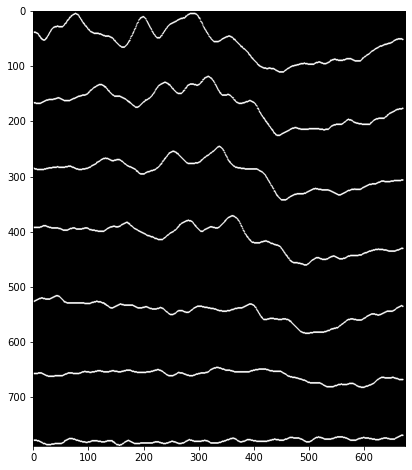

In [5]:
# check end of x-value from graphs
end_of_x = 0
for graph_line in graph_list:
    one_of_end = graph_line["st_end"]["end"]
    if end_of_x == 0 or end_of_x < one_of_end:
        end_of_x = one_of_end

new_graph_list = []
need_reconnect = []

# check the line need to connect
for graph_line in graph_list:
    start = graph_line["st_end"]["start"]
    end = graph_line["st_end"]["end"]
    if start != 0 or end != end_of_x:
        need_reconnect.append({"graph": graph_line, "already_connected": False})
    else:
        new_graph_list.append(graph_line["value"][:end_of_x])

# save information of reconnection
chain = []
for i in range(len(need_reconnect)):
    need_graph_line = need_reconnect[i]
    already_connected = need_graph_line["already_connected"]
    if already_connected is True:
        continue

    graph_line = need_graph_line["graph"]
    end = graph_line["st_end"]["end"]
    graph = graph_line["value"]

    if end != 0:
        for j in range(len(need_reconnect)):
            need_graph_line_2 = need_reconnect[j]
            already_connected_2 = need_graph_line_2["already_connected"]
            if already_connected_2 is True:
                continue

            graph_line_2 = need_graph_line_2["graph"]
            one_of_start = graph_line_2["st_end"]["start"]
            graph_2 = graph_line_2["value"]
            distance = math.sqrt((one_of_start - end) ** 2 + (graph_2[one_of_start] - graph[end]) ** 2)

            if distance < 20:
                # need_graph_line_2["already_connected"] = True
                chain.append((i, j))

# reconnect
def combine(first_idx, second_idx: int):
    if need_reconnect[first] == -1 or need_reconnect[second] == -1:
        return

    first_graph = need_reconnect[first_idx]["graph"]["value"]
    second_graph = need_reconnect[second_idx]["graph"]["value"]
    first_end = need_reconnect[first_idx]["graph"]["st_end"]["end"]
    second_st = need_reconnect[second_idx]["graph"]["st_end"]["start"]
    second_end = need_reconnect[second_idx]["graph"]["st_end"]["end"]
    first_graph[second_st:second_end] = second_graph[second_st:second_end]
    first_graph[first_end:second_st] = [first_graph[first_end] for x in range(first_end, second_st)]

    need_reconnect[first_idx]["graph"]["st_end"]["end"] = second_end

    need_reconnect[second_idx] = -1

for i in range(len(chain)):
    first, second = chain[i]
    for j in range(i, len(chain)):
        x, y = chain[j]

        if x == second:
            combine(x, y)

    combine(first, second)

# remove rest
for line in need_reconnect:
    if line != -1:
        new_graph_list.append(line["graph"]["value"][:end_of_x])

blank1 = np.zeros(crop.shape, np.uint8)

for graph in new_graph_list:
    for i in range(len(graph)):
        y = crop.shape[0] - int(graph[i]) - 1
        x = i

        blank1[y, x] = [255, 255, 255]
        if y > 1:
            blank1[y - 1, x] = [255, 255, 255]

        if y < crop.shape[0] - 1:
            blank1[y + 1, x] = [255, 255, 255]

        if x > 0:
            blank1[y, x - 1] = [255, 255, 255]

        if x < crop.shape[1] - 1:
            blank1[y, x + 1] = [255, 255, 255]

# final graph
plt.figure(figsize=(20,8))
plt.imshow(blank1)

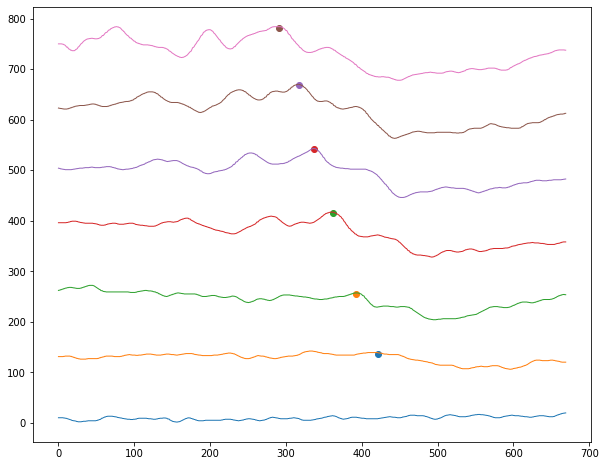

In [6]:
# find peak from the crop

# find candidate of peak list
# do threshold and reverse image
_, threshold = cv2.threshold(crop, 80, 255, cv2.THRESH_BINARY_INV)
# threshold = threshold & (255 - mask)
black = threshold[:, :, 0]

# extend shape of image to remove character in image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
grad = cv2.morphologyEx(black, cv2.MORPH_GRADIENT, kernel)
_, bw = cv2.threshold(grad, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

line_candidates, hierarchy = cv2.findContours(connected, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

blank2 = np.zeros(crop.shape, np.uint8)

for i in range(len(line_candidates)):
    cnt = line_candidates[i]
    area = cv2.contourArea(cnt)
    if 0 < area <= 22:  # remove character candidate (peak's marks are same size and most occurred)
        cv2.drawContours(blank2, line_candidates, i, (0, 255, 0))
intersection = blank1 & blank2  # peak's mark is overlap with graph line

inter_black = cv2.cvtColor(intersection, cv2.COLOR_BGR2GRAY)
inter_black = cv2.dilate(inter_black, np.ones((5, 5), np.uint8), iterations=1)

peak_candidate, _ = cv2.findContours(inter_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
peak_list = []

for candidate in peak_candidate:
    x_list = []
    values = {}
    for array_item in candidate:
        for array_item_2 in array_item:
            x = array_item_2[0]
            y = crop.shape[0] - array_item_2[1]
            if x not in x_list:
                x_list.append(x)
                if x not in values or values[x] > y:
                    values[x] = y

    if len(x_list) == 0:
        x = -1
        y = -1
    else:
        x = int(sum(x_list) / len(x_list))
        y = values[x]
    if end_of_x - 1 <= x <= end_of_x + 1:
        continue
    peak_list.append((x, y))

result = []
for line in new_graph_list:
    peak_point_list = []
    for x, y in peak_list:
        y2 = line[x]
        # find peak in graph
        distance = math.sqrt((x - x) ** 2 + (y2 - y) ** 2)
        if distance < 10:
            peak_point_list.append((x, y))

    result.append({"graph": line, "peak": sorted(peak_point_list, key=lambda v: v[0])})

# show extracted data
plt.figure(figsize=(10,8))

for graph_info in result:
    graph = graph_info["graph"]
    peak_list = graph_info["peak"]
    plt.plot(range(len(graph)), graph, linewidth=1)
    for peak in peak_list:
        plt.scatter(peak[0], peak[1])

plt.show()

## Build model

In [7]:
"""
build model
1. Input1, Input2 : Input1 is the values from the graph, Input2 is one-hot encoding data from the peak index of upper graph (when the graph is top of the image, 0)
2. Bidirectional RNN(LSTM CELL), Dense
3. TimeDistributed, Reshape
4. Concatenate
5. Dense
6. Dense (Output, softmax)
"""
time_step = 670
input_layer_1 = tf.keras.layers.Input([time_step, 1])
input_layer_2 = tf.keras.layers.Input([time_step])

output_1 = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(128, return_sequences=True))(input_layer_1)

output_1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(output_1)

output_2 = tf.keras.layers.Dense(time_step)(input_layer_2)

output_2 = tf.keras.layers.Reshape([time_step, 1])(output_2)

output = tf.keras.layers.Concatenate(axis=2)([output_1, output_2])

output = tf.keras.layers.Dense(1)(output)
output = tf.keras.layers.Flatten()(output)

output = tf.keras.layers.Dense(time_step, activation=tf.keras.activations.softmax)(output)

model = tf.keras.Model(inputs=[input_layer_1, input_layer_2], outputs=[output])
model.summary()

2022-07-14 15:22:30.178680: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 670, 1)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 670)]        0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 670, 256)     133120      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 670)          449570      ['input_2[0][0]']                
                                                                                              

## Result
Train data : 1404  
Test data : 352  
Epoch : 139 (Early stop)  
  
By below image, can see the result of testing

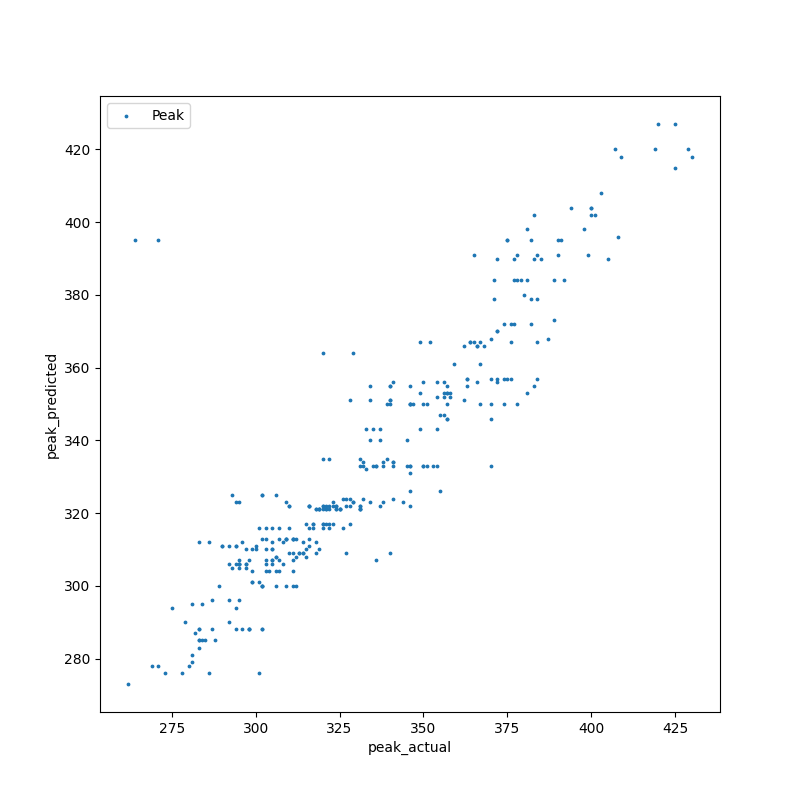

In [8]:
from IPython.display import Image
Image(filename='test_result.png', width=500)

## References
[Tensorflow](https://www.tensorflow.org/)  
[Opencv](https://opencv.org/)  